# Introduction

The goal of this notebook is to develop a Regression Model that will predict rent prices in five big brazilian cities. This model will be deployed with Flask soon.This project uses the data obtained on https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent?select=houses_to_rent_v2.csv

# Importing Major Libraries and Data Analysis

In [1]:
#Importing libraries
%matplotlib inline 
#plots
import matplotlib as mpl
import matplotlib.pyplot as plt
#Data Processing
import pandas as pd
#Math
import numpy as np
#Visualizations
import seaborn as sns


In [2]:
#Loading data
data=pd.read_csv("houses_to_rent_v2.csv")

In [3]:
#Checking basic info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
city                   10692 non-null object
area                   10692 non-null int64
rooms                  10692 non-null int64
bathroom               10692 non-null int64
parking spaces         10692 non-null int64
floor                  10692 non-null object
animal                 10692 non-null object
furniture              10692 non-null object
hoa (R$)               10692 non-null int64
rent amount (R$)       10692 non-null int64
property tax (R$)      10692 non-null int64
fire insurance (R$)    10692 non-null int64
total (R$)             10692 non-null int64
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


Some first observations:

- We dont have null values.
- We have 4 object features.
- We dont have float features.

A first interesting idea would be to create a baseline model.


In [4]:
#Looking at the first 5 rows
data.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


As we want to use this model for future deployment it´s important to be careful in selecting the features.Some first observations on this matter are the following:

- We have to use features that are insteresting to the user.
- It´s important to select features that we can perfome feature engineering

One of the most natural features that we can start looking at is the "city" . As we can see below we have data on 5 southeast big brazilian cities.Most of the entries are from São Paulo city.

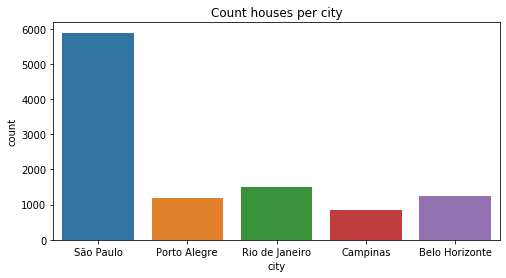

In [5]:
plt.figure(figsize=(8,4))
plt.title("Count houses per city")
data.city.unique()
sns.countplot(x="city",data=data)

Certainly one of the most impactful variables in the total price of a house is the area of the place.Let´s have a look on the relation between both variables.

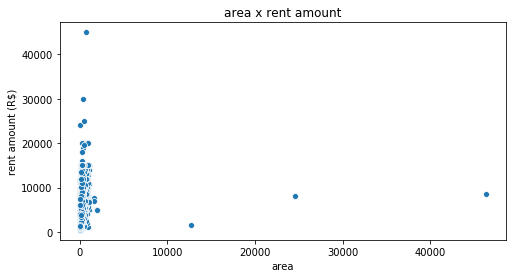

In [6]:
plt.figure(figsize=(8,4))
plt.title("area x rent amount")
sns.scatterplot(x="area",y="rent amount (R$)",data=data)

We just spotted some weird outliers.Dropping those  entries does not represent a big lost in your data and hopefully will improve our analysis and model performance.

In [7]:
#r_data stands for restricted data
r_data=data.loc[(data["rent amount (R$)"]<22000) & (data["area"] < 10000)]

Besides the area of the place other major feature that people consider when searching for a place is the number of rooms.It´s kinda unexpected to see that most of the house to rent have 3 rooms,the number that i was expecting to have the bigger count was 2 rooms.

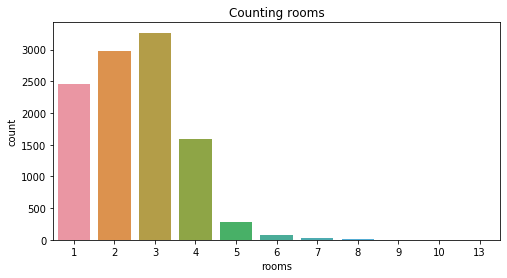

In [8]:
plt.figure(figsize=(8,4))
plt.title("Counting rooms")
sns.countplot(x="rooms",data=r_data)

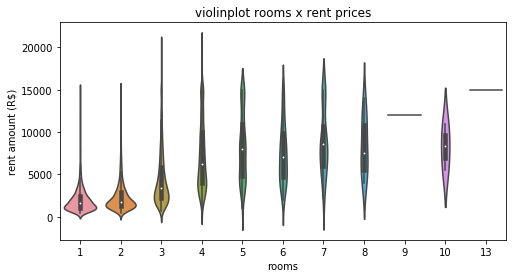

In [9]:
plt.figure(figsize=(8,4))
plt.title("violinplot rooms x rent prices")
sns.violinplot(x="rooms",y="rent amount (R$)",data=r_data)

We see a big jump in the average price of houses with more than  4 rooms.

In [10]:
r_data.loc[r_data["rooms"]>4].count()
#Houses with more than 4 rooms just represent 4% of the dataset.

city                   406
area                   406
rooms                  406
bathroom               406
parking spaces         406
floor                  406
animal                 406
furniture              406
hoa (R$)               406
rent amount (R$)       406
property tax (R$)      406
fire insurance (R$)    406
total (R$)             406
dtype: int64

One feature for which the influence on rent prices is not so clear is "animal acepting".Let´s investigate.

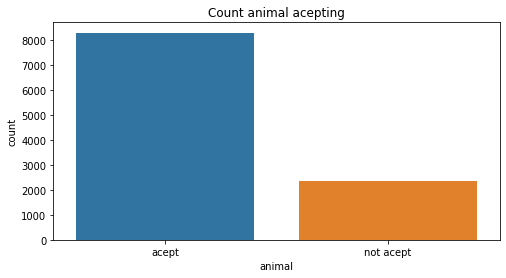

In [11]:
plt.figure(figsize=(8,4))
plt.title("Count animal acepting")
sns.countplot(x="animal",data=r_data)

The proportion of houses that acept animals is close to 4:1. 

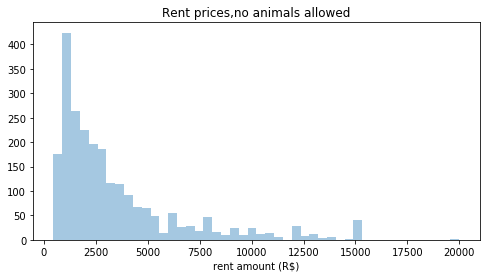

In [12]:
animal_prices=r_data.loc[r_data["animal"]=="not acept","rent amount (R$)"]
plt.figure(figsize=(8,4))
plt.title("Rent prices,no animals allowed")
sns.distplot(a=animal_prices,kde=False)

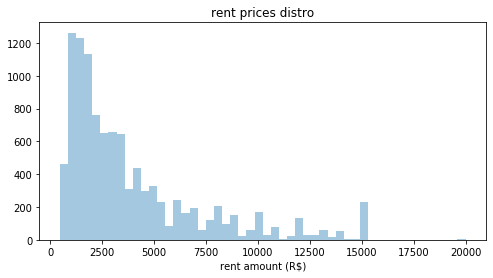

In [13]:
plt.figure(figsize=(8,4))
plt.title("rent prices distro")
sns.distplot(a=r_data["rent amount (R$)"],kde=False)

It´s interesting to see that both distribuitions are similiar.We will leave the  "animal" feature untouched.

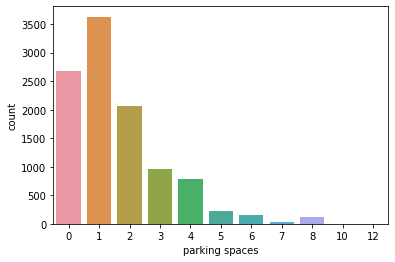

In [14]:
sns.countplot(x="parking spaces",data=r_data)

In [15]:
#Places with 10 (or more) parking spaces
r_data.loc[r_data["parking spaces"]>8]
#Just 3 examples

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
3559,São Paulo,1100,4,6,10,-,acept,not furnished,3000,14000,2000,211,19210
4813,São Paulo,1600,4,5,12,-,acept,not furnished,1,6900,5000,104,12010
5445,São Paulo,190,1,2,10,-,acept,not furnished,0,3900,34,59,3993


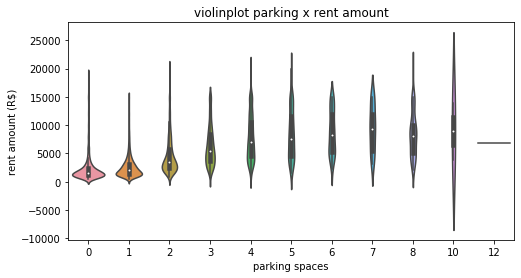

In [16]:
plt.figure(figsize=(8,4))
plt.title("violinplot parking x rent amount")
sns.violinplot(x="parking spaces",y="rent amount (R$)",data=r_data)

The violinplot above allow us to see the natural phenomena of mean rent amount increasing as the number of parking spaces increase as well.

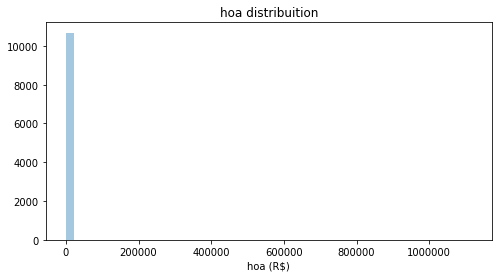

In [50]:
plt.figure(figsize=(8,4))
plt.title("hoa distribuition")
sns.distplot(a=r_data["hoa (R$)"],kde=False)

We again restrict our data to excluse outliers.

In [51]:
scaled_data=r_data.loc[(r_data["hoa (R$)"]<10000) & (r_data["rooms"]<=4)]

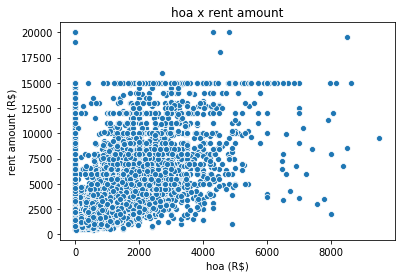

In [52]:
plt.title("hoa x rent amount")
sns.scatterplot(x="hoa (R$)",y="rent amount (R$)",data=scaled_data)

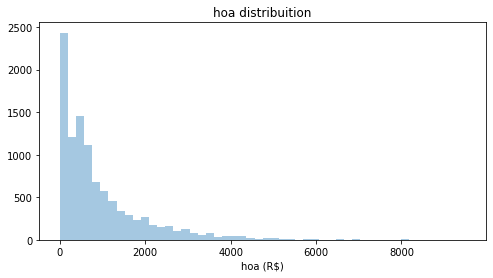

In [66]:
plt.figure(figsize=(8,4))
plt.title("hoa distribuition")
sns.distplot(a=scaled_data["hoa (R$)"],kde=False)

In [65]:
scaled_data["hoa (R$)"].describe()

count    10272.000000
mean       915.333236
std       1065.526117
min          0.000000
25%        210.000000
50%        577.500000
75%       1250.000000
max       9500.000000
Name: hoa (R$), dtype: float64

In [53]:
#Selecting Features
features=["city","area","rooms","bathroom","animal","furniture","hoa (R$)"]
X=scaled_data[features]
#Selecting Target
y=scaled_data['rent amount (R$)']
y

0         3300
1         4960
2         2800
3         1112
4          800
         ...  
10687     1478
10688    15000
10689     6000
10690    12000
10691     1400
Name: rent amount (R$), Length: 10272, dtype: int64

In [54]:
y.describe()

count    10272.000000
mean      3713.712519
std       3225.230127
min        450.000000
25%       1500.000000
50%       2500.000000
75%       4600.000000
max      20000.000000
Name: rent amount (R$), dtype: float64

# Modeling 

## A preliminary investigation Random Forest vs Linear Regression.

In [55]:
#Splitting data between train and test
from sklearn.model_selection import train_test_split
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)


In [56]:
#Importing Encoder to work with categorical features
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
#Choosing features to enconde
object_cols=["city","animal","furniture"]
#We copy because we don´t want to change the original data.
label_X_train = X_train_full.copy()
label_X_valid = X_valid_full.copy()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(label_X_train[col])
    label_X_valid[col] = label_encoder.fit_transform(label_X_valid[col])
label_X_valid

,city,area,rooms,bathroom,animal,furniture,hoa (R$)
4923,3,59,2,1,1,0,1400
2561,4,144,4,2,0,1,1820
10286,4,300,3,2,0,0,0
9130,1,50,1,1,1,1,298
8282,4,250,3,4,0,1,3421
...,...,...,...,...,...,...,...
7868,4,60,2,2,0,0,625
5852,4,240,3,5,0,0,3500
1677,4,48,2,1,0,1,545
6293,3,70,2,1,0,0,843


In [57]:
from  sklearn.ensemble import RandomForestRegressor

#Define model
#Parameters were manually chosen
base_model=RandomForestRegressor(n_estimators=200,max_depth=10,
                                 random_state=42)
#Fitting Model
base_model.fit(label_X_train,y_train)

#Predicting 
predictions=base_model.predict(label_X_valid)

In [58]:
#Evaluating Our Model
from sklearn.metrics import mean_absolute_error
train_pred=base_model.predict(label_X_train)
print("MAE on train set",mean_absolute_error(train_pred,y_train))
print("MAE on validation set",mean_absolute_error(predictions,y_valid))

MAE on train set 987.4515062850375
MAE on validation set 1194.5204116504017


In [59]:
print(predictions[:20])
print(y.head(20))

[2733.99971944 4763.71629686 6058.7172325  1001.36278849 8625.37278141
 2806.96821001 7089.84980967 6825.20702315 4492.91258546 3683.18285353
 5580.96306322 7968.50755588 1640.9617999  6494.71277503 1761.10310676
 7355.25725341 5831.52943067 1143.63785111 2122.49533969 6112.41294477]
0      3300
1      4960
2      2800
3      1112
4       800
5      8000
6      1900
7      3223
8     15000
9      2300
10     2100
11      580
12     2100
13     4200
14     4370
15     8000
16     3000
17     3500
18     1220
19    12000
Name: rent amount (R$), dtype: int64


Two observations here:

- Our present error is not so bad,but can be lowered by futher cleaning the data.
- It´s worth to try crossvalidation scoring in the future.

In [61]:
from sklearn.linear_model import LinearRegression
#Defining Model
lr_model = LinearRegression()

#Fiting
lr_model.fit(label_X_train,y_train)

#Predict
linear_pred=lr_model.predict(label_X_valid)

#MAE
print(mean_absolute_error(linear_pred,y_valid))

1285.7171969580525


As we can see The RandomForest performs reasonably better than the Linear Regression.